In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
from tqdm import tqdm
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [24]:
# Loading the dataset
zomato = pd.read_csv('zomato.csv')

In [25]:
# Exploring the dataset
display(zomato.head())

# Shape of the dataset
zomato.shape

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


(51717, 17)

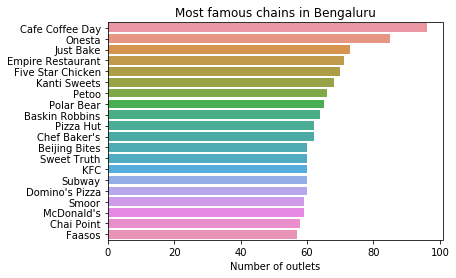

In [4]:
# Plotting top chains in bengaluru
%matplotlib inline
bestRest = zomato['name'].value_counts()[:20]
sns.barplot(x=bestRest.values, y=bestRest.index)
plt.title('Most famous chains in Bengaluru')
plt.xlabel('Number of outlets')
plt.show()

In [5]:
"Not surprisingly most famous chain is Cafe Coffee Day, with Onesta and Just Bake coming in second. Surprisingly fast\
food chains such as Pizza hut and Dominos are way behind"

'Not surprisingly most famous chain is Cafe Coffee Day, with Onesta and Just Bake coming in second. Surprisingly fastfood chains such as Pizza hut and Dominos are way behind'

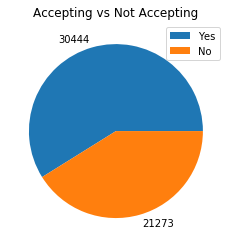

In [6]:
# How many accept or not accept online orders
OnlineOrd = zomato['online_order'].value_counts()
labels = ['Yes', 'No']
plt.pie(OnlineOrd, labels = OnlineOrd)
plt.legend(labels)
plt.title('Accepting vs Not Accepting')
plt.show()

In [7]:
"As clearly indicated,almost 60 per cent of restaurants in Banglore accepts online orders.\
Nearly 40 per cent of the restaurants do not accept online orders.\
This might be because of the fact that these restaurants cannot afford to pay commission to zomoto for giving them orders online. zomato may want to consider giving them some more benefits if they want to increse the number of restaurants serving their customers online."

'As clearly indicated,almost 60 per cent of restaurants in Banglore accepts online orders.Nearly 40 per cent of the restaurants do not accept online orders.This might be because of the fact that these restaurants cannot afford to pay commission to zomoto for giving them orders online. zomato may want to consider giving them some more benefits if they want to increse the number of restaurants serving their customers online.'

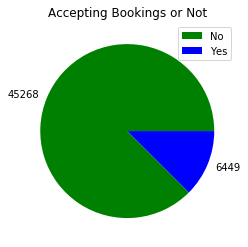

In [8]:
# How many accpet tables booking
BookOrd = zomato['book_table'].value_counts()
labels = ['No', 'Yes']
plt.pie(BookOrd, labels = BookOrd, colors = ['green', 'blue'])
plt.legend(labels)
plt.title('Accepting Bookings or Not')
plt.show()

In [9]:
#Almost 90 percent of restaurants in Banglore do not provide table booking facility.
#In India you cannot find table booking facility in any average restaurants,usually only five star restaurants 
#provides table booking.

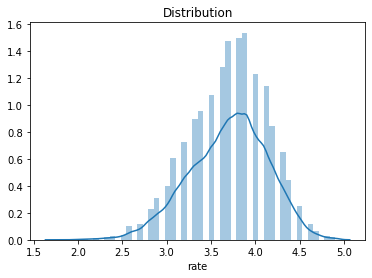

In [10]:
# Looking at the distribution of the ratings
ratings = zomato['rate'].dropna()
# Preparing the data for visualization
ratings=ratings.apply(lambda x: float(x.split('/')[0]) if len(x)>3 else np.nan).dropna()
#Making a distplot
sns.distplot(ratings)
plt.title('Distribution')
plt.show()

In [11]:
#Almost more than 50 percent of restaurants has rating between 3 and 4. Restaurants having rating more than 
#4.5 are very rare.

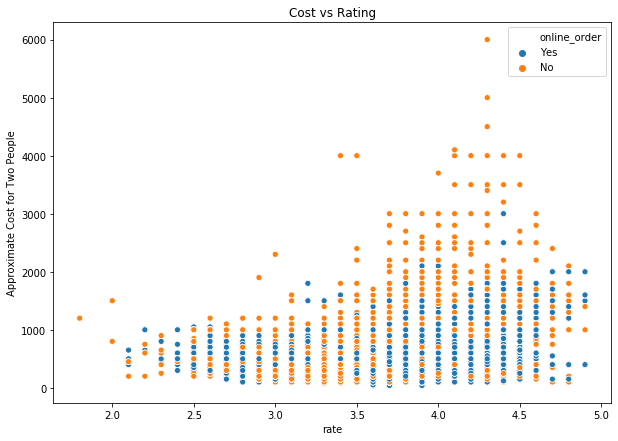

In [12]:
# Making a cost vs rating scatterplot
plt.figure(figsize=(10,7))
# Cleaning data for scatterplot
cost = zomato['approx_cost(for two people)'].dropna()
cost = cost.apply(lambda x: int(x.replace(',','')))
# Making a scatterplot
sns.scatterplot(ratings, cost, hue = zomato['online_order'])
plt.title('Cost vs Rating')
plt.ylabel('Approximate Cost for Two People')
plt.show()

In [13]:
# Almost 90 percent of food vendors sell food for less than 2000 Rs.

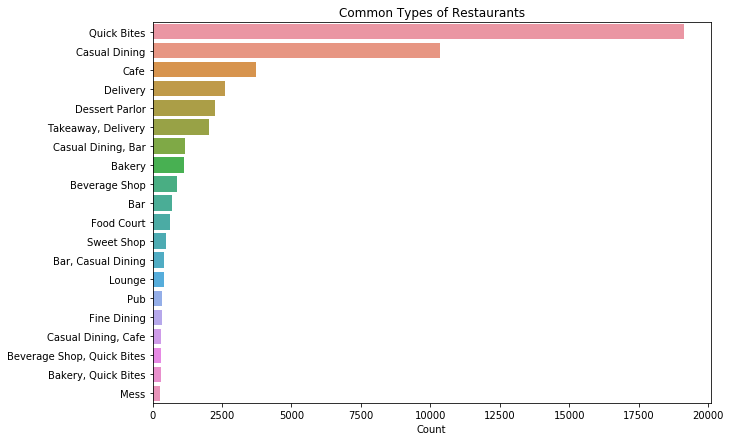

In [14]:
# Most Common Types of Restaurant
plt.figure(figsize=(10,7))
RestType = zomato['rest_type'].value_counts()[:20]
sns.barplot(RestType.values, RestType.index)
plt.title('Common Types of Restaurants')
plt.xlabel('Count')
plt.show()

In [15]:
# No surprise that quick bites dominates as Banglore being IT capital of India, people prefer Quick Bites.
# Surprised to see that Mess is at the lowest.

In [16]:

"""
locations=pd.DataFrame({"Name":zomato['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x: "Bangalore " + str(x))
lat_lon=[]
geolocator=Nominatim(user_agent="app", timeout=10)
for location in locations['Name']:
    location = geolocator.geocode(location)
    if location is None:
        lat_lon.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        lat_lon.append(geo)


locations['geo_loc']=lat_lon
locations.to_csv('locations.csv',index=False)
"""

'\nlocations=pd.DataFrame({"Name":zomato[\'location\'].unique()})\nlocations[\'Name\']=locations[\'Name\'].apply(lambda x: "Bangalore " + str(x))\nlat_lon=[]\ngeolocator=Nominatim(user_agent="app", timeout=10)\nfor location in locations[\'Name\']:\n    location = geolocator.geocode(location)\n    if location is None:\n        lat_lon.append(np.nan)\n    else:    \n        geo=(location.latitude,location.longitude)\n        lat_lon.append(geo)\n\n\nlocations[\'geo_loc\']=lat_lon\nlocations.to_csv(\'locations.csv\',index=False)\n'

In [17]:
# Loading Locations csv
locations = pd.read_csv('locations.csv')

In [26]:
# Making word cloud for every dished liked
# Preparing the dataset for word cloud by getting different dishes using split.
zomato['dish_liked1'] = zomato['dish_liked'].apply(lambda x: x.split(',') if type(x)==str else [''])



In [36]:
# Getting different restaurant type
restType = zomato['rest_type'].value_counts()[:9]

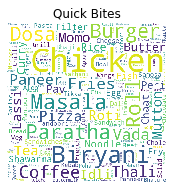

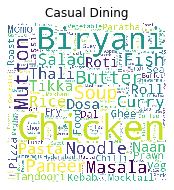

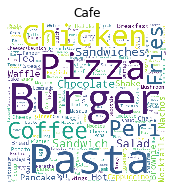

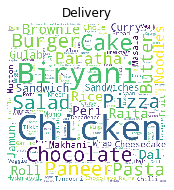

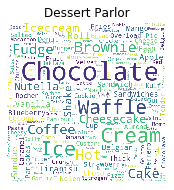

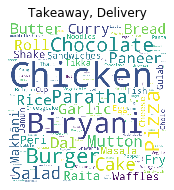

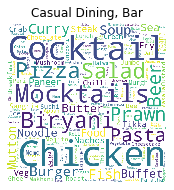

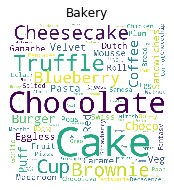

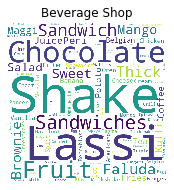

In [76]:
# Getting most common dishes for each type of restaurant
i = 0
for rest in restType.index:
    plt.figure(figsize=(10,10))
    plt.subplot(3, 3, i+1)
    
    # Getting the dishes for different restaurant types
    corpus = zomato[zomato['rest_type']==rest]['dish_liked1'].values.tolist()
    
    # Getting All the dishes
    corpus = ','.join(x for words in corpus for x in words)
    
    # Generating Word Cloud
    wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=500, height=500).generate(corpus)
    
    plt.imshow(wordcloud)
    plt.title(rest)        
    plt.axis("off")
    i+=1

['Berryblast', ' Waffles', ' Cheesecake', ' Salted Caramel']